In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy import Column, Integer, String, Float, Date

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
base = automap_base()

# reflect the tables
base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [9]:
#Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
inspector = inspect(engine)

columns = inspector.get_columns('measurement')
for c in columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
columns = inspector.get_columns('station')
for c in columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
def convert(date_time):
    format = "%Y-%m-%d"
    datetime = dt.datetime.strptime(date_time, format)
    
    return datetime
    
last_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(last_date)

one_year = convert(last_date[0]) - dt.timedelta(days=365)
print(one_year)

('2017-08-23',)
2016-08-23 00:00:00


In [14]:
# Perform a query to retrieve the data and precipitation scores
session.query(measurement.date, measurement.prcp).filter(measurement.date >= one_year)
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_query = session.query(measurement.date, measurement.prcp).filter(measurement.date >= one_year)

precip_df = pd.DataFrame(precip_query)
precip_df = precip_df.set_index("date", drop=False)
precip_df = precip_df.dropna()
precip_df.head()


,date,prcp
date,,
2016-08-24,2016-08-24,0.08
2016-08-25,2016-08-25,0.08
2016-08-26,2016-08-26,0.00
2016-08-27,2016-08-27,0.00
2016-08-28,2016-08-28,0.01


In [15]:
# Sort the dataframe by date
precip_df = precip_df.sort_index()

precip_df = precip_df.rename(columns=
                            {'date':'Date',
                            'prcp':'Precipitation'})
precip_df.head()

,Date,Precipitation
date,,
2016-08-24,2016-08-24,0.08
2016-08-24,2016-08-24,1.22
2016-08-24,2016-08-24,2.28
2016-08-24,2016-08-24,1.45
2016-08-24,2016-08-24,2.15


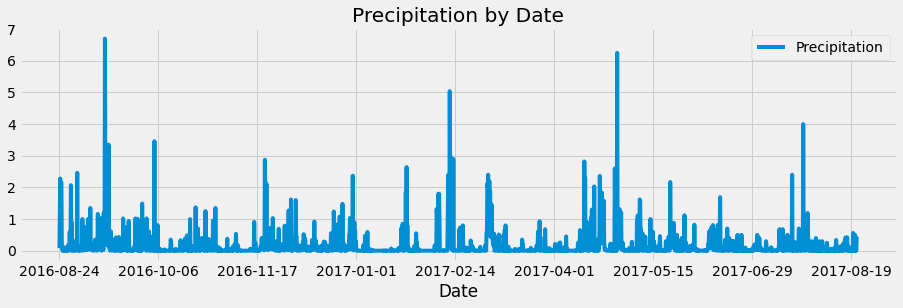

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
title = 'Precipitation by Date'

precip_plot = precip_df.plot(x='Date',y='Precipitation', kind='line', figsize=(14,4), title=title)
precip_plot.set_ylabel = 'Precipitation (Inches)'
plt.show()



In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
columns = inspector.get_columns('station')
for c in columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [26]:
# Design a query to show how many stations are available in this dataset?
session.query(station.id).count()

9

In [43]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active = [measurement.station,func.count(measurement.id)]

active_stations = session.query(*active).group_by(measurement.station).order_by(func.count(measurement.id).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [59]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
active_min = (session.query(func.min(measurement.tobs)).filter(measurement.date >= one_year).filter(measurement.station == "USC00519281").all())

active_max = (session.query(func.min(measurement.tobs)).filter(measurement.date >= one_year).filter(measurement.station == "USC00519281").all())

active_avg = (session.query(func.avg(measurement.tobs)).filter(measurement.date >= one_year).filter(measurement.station == "USC00519281").all())

print(f"The lowest recorded temperature is {active_min} degrees.")
print(f"The highest recorded temperature is {active_max} degrees.")
print(f"The average recorded temperature is {round(active_avg[0][0], 1)} degrees.")

The lowest recorded temperature is [(59.0,)] degrees.
The highest recorded temperature is [(59.0,)] degrees.
The average recorded temperature is 73.1 degrees.


In [87]:
# Choose the station with the highest number of temperature observations.

station_year = (session.query(measurement.date, measurement.tobs).filter(measurement.date >= one_year).filter(measurement.station == "USC00519281"))
station_year_df = pd.read_sql_query(station_year.statement, session.get_bind())
station_year_df["date"] = pd.to_datetime(station_year_df["date"])
station_year_df.head()

,date,tobs
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


In [88]:
# plt.hist(station_year_df, bins=12)
# plt.xlabel("Temperature (F)")
# plt.ylabel("Frequency")
# plt.title("Temperature Frequency at most Active Station" + " - " + station_activity[0][2])
# plt.show()

In [89]:
# Create bin_list to hold dates as strings
bin_list = ["2016-08-22", "2016-09-22", "2016-10-22", "2016-11-22", "2016-12-22", "2017-01-22", "2017-02-22",
            "2017-03-22", "2017-04-22", "2017-05-22", "2017-06-22", "2017-07-22", "2017-08-24"]

# Run datetime function on bin_list, and add to list of size_bins
size_bins = []
for x in bin_list:
    date = convert(x)
    size_bins.append(date)

In [90]:

# Create labels for bins
group_names = ["Sep 2016", "Oct 2016", "Nov 2016", "Dec 2016", "Jan 2017","Feb 2017",
              "Mar 2017", "Apr 2017", "May 2017", "Jun 2017", "Jul 2017", "Aug 2017"]

# Cut the bins
station_year_df["Month"] = pd.cut(station_year_df["date"], bins=size_bins, labels=group_names)
station_year_df = station_year_df.sort_values(by="date")
station_year_df.head()

,date,tobs,Month
0,2016-08-24,77.0,Sep 2016
1,2016-08-25,80.0,Sep 2016
2,2016-08-26,80.0,Sep 2016
3,2016-08-27,75.0,Sep 2016
4,2016-08-28,73.0,Sep 2016


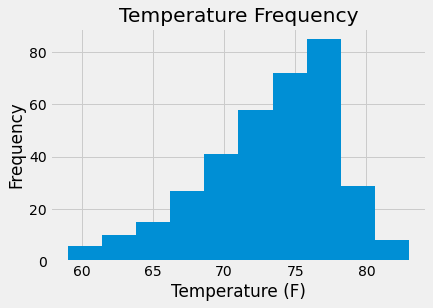

In [94]:
station_freq = station_year_df["tobs"].plot(kind="hist", title="Temperature Frequency")
station_freq.set_xlabel("Temperature (F)")
plt.show()